# Scene_pipeline notebook file

This notebook is trying to explain what and how we have done about scenes

## Step 1 — Export building footprints from roof meshes (PLY → JSON)

We use `export_roof_footprints.py` to extract **per-building 2D roof footprints** (XY polygon) and **height** from roof-only PLY meshes.

### Input
- One roof PLY file (`--ply ...`) **or** a directory of roof PLY files (`--dir ...`, default pattern `*-roof.ply`)
- Assumption: vertices in the PLY are already in **world coordinates**.

### Output
- A JSON file with:
  - `meta`: summary statistics, per-file stats, and extraction settings
  - `buildings`: a list of building records (AABB + footprint polygon + roof height)

Each building record includes:
- `xmin/xmax/ymin/ymax/zmin/zmax` (axis-aligned bounding box)
- `center`, `size`
- `footprint`: polygon vertices in the XY plane (currently **convex hull**)
- `roof_zmax`: roof max height
- `building_id`, `source_ply` (traceability)

### Key assumptions / limitations
- Buildings are approximated by **connected components** in the roof mesh.
- Footprint is computed via **2D convex hull** (robust but may over-estimate concave roofs).
- Building `zmin` is overridden to a constant (default `0.0`) to approximate extrusion down to ground.


### Usage (CLI)

**Single roof file**
```bash
python export_roof_footprints.py \
  --ply /path/to/xxx-roof.ply \
  --out /path/to/buildings.json \
  --zmin 0.0
```

### Directory of roof files

```
python export_roof_footprints.py \
  --dir /path/to/roof_meshes/ \
  --pattern "*-roof.ply" \
  --out /path/to/buildings.json \
  --zmin 0.0 \
  --min_comp_verts 50

# Example: run extraction inside notebook (optional)
SCENE_ROOT = "/path/to/scene_data"
ROOF_DIR = f"{SCENE_ROOT}/meshes"
OUT_JSON = f"{SCENE_ROOT}/buildings.json"

!python export_roof_footprints.py --dir "{ROOF_DIR}" --out "{OUT_JSON}" --zmin 0.0 --min_comp_verts 50
```

## Show general statistics of scenes

### General statistics of scenes

After generating the building-level scene JSON files, we summarize the geometric
properties of all available scenes.

This step provides a **global overview** of the dataset and answers questions such as:
- How many buildings are present in each scene?
- What is the spatial extent of each city?
- How tall are buildings in different scenes?
- Are there obvious outliers or malformed scenes?

The statistics reported here are **fully deterministic** and derived directly from
the generated `*_buildings.json` files. They serve as a quantitative reference for
scene comparison and downstream experimental design.


In [1]:
from pathlib import Path
from notebook_utils import summarize_scenes_in_dir

SCEN_DIR = Path("~/Projects/metaRL_merged/scenarios").expanduser()

df_scenes = summarize_scenes_in_dir(
    SCEN_DIR,
    pattern="*_buildings.json",
    sort_by="n_buildings_valid",
    descending=True,
)

# Display a compact, comparable view
display(
    df_scenes[
        [
            "scene",
            "n_buildings_valid",
            "bad_records",
            "x_range",
            "y_range",
            "area_xy",
            "height_p50",
            "height_p90",
            "height_max",
        ]
    ]
)


,scene,n_buildings_valid,bad_records,x_range,y_range,area_xy,height_p50,height_p90,height_max
0,sf,2515,0,2111.323120,1888.345337,3.986907e+06,26.638607,71.538968,252.389633
1,boston,2094,0,2251.825073,1772.018188,3.990275e+06,13.116180,27.435900,234.000000
2,chicago,2090,0,2021.449646,1709.452820,3.455573e+06,13.179043,23.474691,152.527969
3,atlanta,1985,0,2089.631958,1944.025085,4.062297e+06,39.493416,106.145163,2319.515625
4,seattle,1634,0,2190.445068,1569.958069,3.438907e+06,89.493443,139.876999,294.155853
5,la,1379,0,2199.084595,1979.590393,4.353287e+06,23.337032,66.368513,336.076630
6,chapel,1361,0,1984.723816,1850.966492,3.673657e+06,55.893177,68.524315,102.909439
7,durham,1348,0,1979.968201,1937.095764,3.835388e+06,31.756677,44.201920,108.537216
8,charlotte,1260,0,2117.569702,2000.649353,4.236514e+06,48.330605,67.645203,269.091400
9,raleigh,924,0,1516.177185,1221.405823,1.851868e+06,7.673306,18.071890,142.000000


### Detailed statistics for a selected scene

While the previous section provides a global overview, we now focus on a single
representative scene and report its detailed geometric statistics.

This step is useful for:
- Verifying that the scene geometry matches expectations
- Inspecting building height distributions and spatial coverage
- Serving as a concrete reference example for later visualization and experiments


In [2]:
from notebook_utils import summarize_buildings_json
import pandas as pd

SCENE_NAME = "raleigh"
json_path = SCEN_DIR / f"{SCENE_NAME}_buildings.json"

scene_stats = summarize_buildings_json(str(json_path))
df_scene = pd.DataFrame([scene_stats])

display(
    df_scene[
        [
            "scene",
            "n_buildings_valid",
            "bad_records",
            "x_range",
            "y_range",
            "area_xy",
            "height_min",
            "height_p50",
            "height_p90",
            "height_max",
            "footprint_pts_mean",
        ]
    ]
)


,scene,n_buildings_valid,bad_records,x_range,y_range,area_xy,height_min,height_p50,height_p90,height_max,footprint_pts_mean
0,raleigh,924,0,1516.177185,1221.405823,1.851868e+06,3.982634,7.673306,18.07189,142.0,6.04329


### Sanity check of building geometry

Before visualizing or using the scene for simulation, we perform a lightweight
sanity check on the building geometry.

This check is designed to quickly detect:
- Missing or invalid AABB fields
- Degenerate or malformed footprint polygons
- Abnormal height ranges

The goal is to ensure that the scene JSON is safe to use in downstream pipelines
such as visibility checking, collision detection, and learning-based optimization.


In [3]:
from notebook_utils import sanity_check_buildings

sanity_summary = sanity_check_buildings(str(json_path))


{
  "num_buildings": 924,
  "x_range": [
    -776.8180541992188,
    739.359130859375
  ],
  "y_range": [
    -597.7220458984375,
    623.6837768554688
  ],
  "z_range": [
    0.0,
    142.0
  ],
  "height_stats": {
    "min": 3.982633590698242,
    "median": 7.673306465148926,
    "max": 142.0
  },
  "invalid_footprints_lt3": 0,
  "missing_or_bad_aabb": 0,
  "meta_keys": [
    "assumption",
    "files",
    "footprint_method",
    "num_components_dropped",
    "num_components_kept",
    "num_components_total",
    "num_roof_files",
    "pattern",
    "source_dir"
  ]
}

Sample building records (first few ids):
  - 213_North_Bloodworth_Apartments-roof__element_00000, footprint_pts=7
  - 227_Fayetteville_Street-roof__element_00000, footprint_pts=4
  - 301_Hillsborough-roof__element_00000, footprint_pts=9
  - Acme_Cleaners-roof__element_00000, footprint_pts=4
  - Alexander_Square_Parking_Deck-roof__element_00000, footprint_pts=4
  - American_Underground___Raleigh-roof__element_00000, foo

### Deterministic footprint visualization

We visualize the building footprints in a 2D top-down view to complement the
numerical statistics.

This visualization helps verify:
- Global spatial layout
- Alignment between building footprints and AABBs
- Presence of obvious geometric artifacts

To ensure reproducibility, the visualization uses:
- A fixed scene JSON
- A fixed maximum number of buildings
- No random sampling


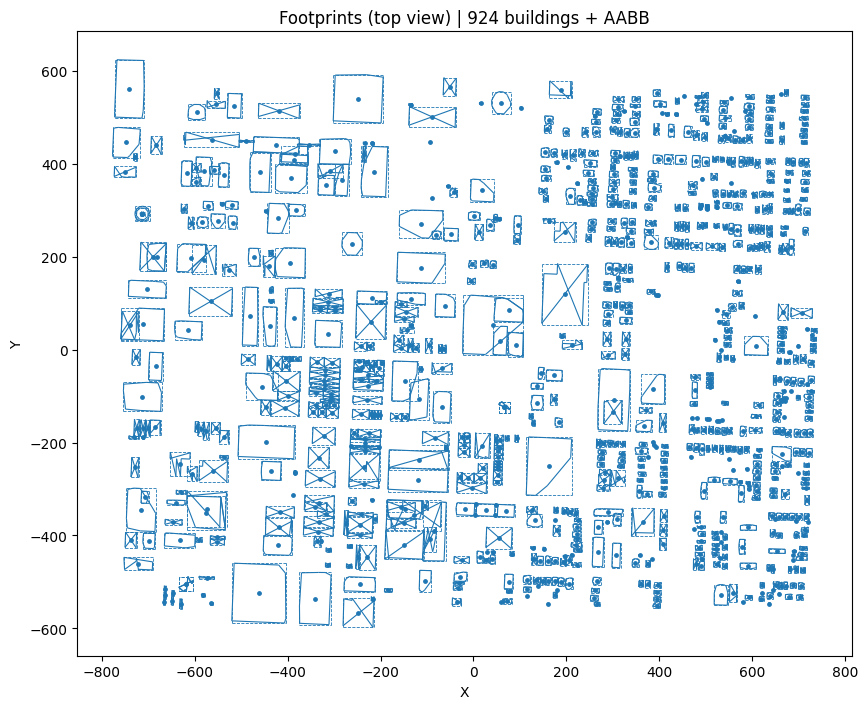

In [4]:
from notebook_utils import plot_footprints_2d

plot_footprints_2d(
    str(json_path),
    max_buildings=2000,
    show_aabb=True,
    show_centers=True,
)


### Raw XML and mesh-level sanity checks (optional)

As an optional diagnostic step, we inspect the original XML scene description and
raw mesh assets.

These checks provide coarse-grained validation that:
- The processed scene JSON is consistent with the original assets
- The spatial scale and bounds of the raw geometry are reasonable

Only minimal, deterministic information is extracted at this stage.


In [5]:
from notebook_utils import parse_scene_xml_summary, compute_mesh_dir_bounds

base_path = "scenarios/Atlanta-(Midtown)"
xml_file = f"{base_path}/final-scene.xml"
mesh_dir = f"{base_path}/meshes"

_ = parse_scene_xml_summary(xml_file)
bounds_min, bounds_max, n_mesh = compute_mesh_dir_bounds(mesh_dir)


--- XML summary ---
root tag: scene
num named objects: 25
first 10 names: ['elm__0', 'max_depth', 'mat-itu_concrete', 'bsdf', 'reflectance', 'mat-itu_wet_ground', 'bsdf', 'reflectance', 'elm__4', 'filename']
--- Mesh dir stats ---
mesh files: 12
span (X,Y,Z): [2089.63195801 1944.02508545 2318.78392792]
center: [-3.86901855e-01 -2.81863403e+00  1.16100037e+03]
